In [1]:
%load_ext autoreload
%autoreload 2
from CNN import AudioClassifier
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, create_sampler
from training_pipeline import repeat_training
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

SEED = 42
set_seed(SEED)

In [3]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

In [4]:
# oversampling
sampler = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers)

In [5]:
repetitions = 1
lr = 0.001
epochs = 100
tolerance = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dir = "output/models/cnn"
history_dir = "output/history/cnn"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

model_path = model_dir + "/cnn.pth"
history_path = history_dir + "/cnn.pkl"

repeat_training(repetitions, AudioClassifier, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance)

training iteration: 1 of 1
starting training...
epoch: 1, training loss: 0.0021524135008188314, training accuracy: 19.231522079549013
epoch: 1, validation loss: 0.002458987042426221, validation accuracy: 11.827007943512799
model saved

epoch: 2, training loss: 0.0017433310825362535, training accuracy: 34.338787973692455
epoch: 2, validation loss: 0.0020561556003836543, validation accuracy: 18.255369226243012
model saved

epoch: 3, training loss: 0.001486587208936926, training accuracy: 44.14343877231444
epoch: 3, validation loss: 0.0019412664639034422, validation accuracy: 23.845248602530155
model saved

epoch: 4, training loss: 0.0013488622465702646, training accuracy: 50.0
epoch: 4, validation loss: 0.0017970488961565737, validation accuracy: 30.03824654310091
model saved

epoch: 5, training loss: 0.001242024201585923, training accuracy: 54.56075790792358
epoch: 5, validation loss: 0.0016988173552420814, validation accuracy: 33.568696675492795
model saved

epoch: 6, training loss: 0.

In [6]:
best_model = AudioClassifier()
best_model.to(device)
best_model.load_state_dict(torch.load("output/models/cnn/cnn_1.pth", weights_only=True))

<All keys matched successfully>

In [7]:
all_preds = []
best_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().tolist())

pred_counts = Counter(all_preds)
sorted_pred_counts = dict(sorted(pred_counts.items()))
print(sorted_pred_counts)

{0: 466, 1: 526, 2: 278, 3: 469, 4: 476, 5: 698, 6: 480, 7: 410, 8: 591, 9: 274, 10: 2167}


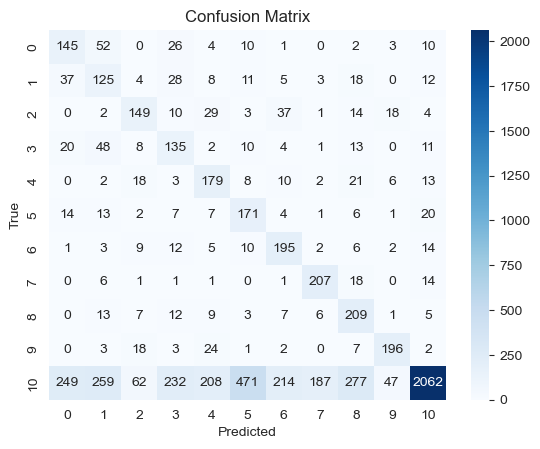

In [8]:
true_labels = []
predictions = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        
        true_labels.extend(y.cpu().tolist())
        predictions.extend(predicted.cpu().tolist())

unique_labels = np.unique(true_labels)
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Historical results on unbalanced dataset

In [7]:
best_model = AudioClassifier()
best_model.to(device)
best_model.load_state_dict(torch.load("output/models/cnn/cnn_2.pth", weights_only=True))

<All keys matched successfully>

In [8]:
all_preds = []
best_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().tolist())

pred_counts = Counter(all_preds)
sorted_pred_counts = dict(sorted(pred_counts.items()))
print(sorted_pred_counts)

{0: 193, 2: 318, 4: 59, 6: 144, 7: 194, 8: 77, 9: 270, 10: 5580}


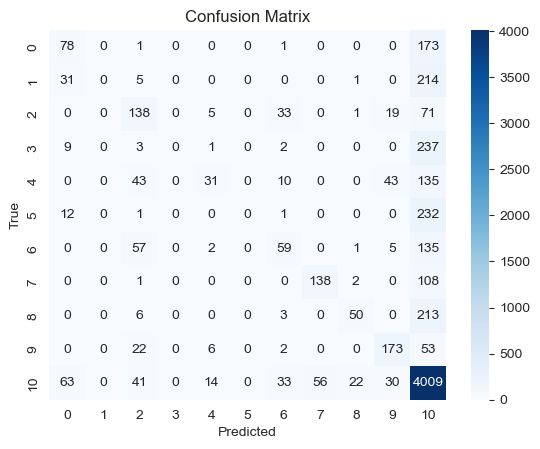

In [9]:
true_labels = []
predictions = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        
        true_labels.extend(y.cpu().tolist())
        predictions.extend(predicted.cpu().tolist())

unique_labels = np.unique(true_labels)
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()